In [ ]:
!pip install tensorflow-probability


In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd

In [ ]:
tfd = tfp.distributions
data = pd.read_csv('/content/Student Stress Factors (1).csv')
COLUMN_NAMES = [
    'Kindly Rate your Sleep Quality 😴',
    'How many times a week do you suffer headaches 🤕?',
    'How would you rate you academic performance 👩‍🎓?',
    'how would you rate your study load?',
    'How many times a week you practice extracurricular activities 🎾?',
    'How would you rate your stress levels?'
]

In [ ]:
def convert_and_cast(column):
    return tf.convert_to_tensor(data[column].values, dtype=tf.float32)

sleep_quality = convert_and_cast(COLUMN_NAMES[0])
headache_frequency = convert_and_cast(COLUMN_NAMES[1])
academic_performance = convert_and_cast(COLUMN_NAMES[2])
study_load = convert_and_cast(COLUMN_NAMES[3])
extracurricular_activity = convert_and_cast(COLUMN_NAMES[4])
stress_levels = convert_and_cast(COLUMN_NAMES[5])

In [ ]:
def joint_log_prob(sleep_quality, headache_frequency, academic_performance, study_load, extracurricular_activity, stress_levels, intercept, sleep_coef, headache_coef, academic_coef, study_coef, extracurricular_coef, sigma):
    rv_intercept = tfd.Normal(loc=0., scale=10.)
    rv_sleep_coef = tfd.Normal(loc=0., scale=10.)
    rv_headache_coef = tfd.Normal(loc=0., scale=10.)
    rv_academic_coef = tfd.Normal(loc=0., scale=10.)
    rv_study_coef = tfd.Normal(loc=0., scale=10.)
    rv_extracurricular_coef = tfd.Normal(loc=0., scale=10.)
    rv_sigma = tfd.Exponential(rate=1.0)

    mu = (intercept + sleep_coef * sleep_quality +
          headache_coef * headache_frequency +
          academic_coef * academic_performance +
          study_coef * study_load +
          extracurricular_coef * extracurricular_activity)

    rv_stress_levels = tfd.Normal(loc=mu, scale=sigma)

    return (
        rv_intercept.log_prob(intercept) +
        rv_sleep_coef.log_prob(sleep_coef) +
        rv_headache_coef.log_prob(headache_coef) +
        rv_academic_coef.log_prob(academic_coef) +
        rv_study_coef.log_prob(study_coef) +
        rv_extracurricular_coef.log_prob(extracurricular_coef) +
        rv_sigma.log_prob(sigma) +
        tf.reduce_sum(rv_stress_levels.log_prob(stress_levels))
    )
initial_state = [
    tf.zeros([], name='init_intercept', dtype=tf.float32),
    tf.zeros([], name='init_sleep_coef', dtype=tf.float32),
    tf.zeros([], name='init_headache_coef', dtype=tf.float32),
    tf.zeros([], name='init_academic_coef', dtype=tf.float32),
    tf.zeros([], name='init_study_coef', dtype=tf.float32),
    tf.zeros([], name='init_extracurricular_coef', dtype=tf.float32),
    tf.ones([], name='init_sigma', dtype=tf.float32),
]
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=lambda intercept, sleep_coef, headache_coef, academic_coef, study_coef, extracurricular_coef, sigma: joint_log_prob(
        sleep_quality, headache_frequency, academic_performance, study_load, extracurricular_activity, stress_levels,
        intercept, sleep_coef, headache_coef, academic_coef, study_coef, extracurricular_coef, sigma),
    step_size=0.01,
    num_leapfrog_steps=3)
num_results = 1000
num_burnin_steps = 500


In [ ]:
def run_chain():
    return tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        kernel=hmc_kernel,
        trace_fn=lambda _, pkr: pkr.is_accepted)

states, is_accepted = run_chain()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
intercept_samples = states[0].numpy()
sleep_coef_samples = states[1].numpy()
headache_coef_samples = states[2].numpy()
academic_coef_samples = states[3].numpy()
study_coef_samples = states[4].numpy()
extracurricular_coef_samples = states[5].numpy()
sigma_samples = states[6].numpy()
acceptance_rate = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32)).numpy()
print('Acceptance rate:', acceptance_rate)

Acceptance rate: 0.989


Intercept: Mean = -0.2358, Standard deviation = 0.4623


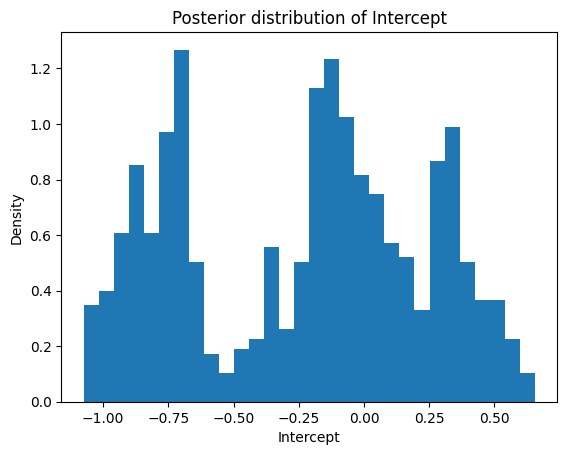

Sleep Coefficient: Mean = 0.4477, Standard deviation = 0.1262


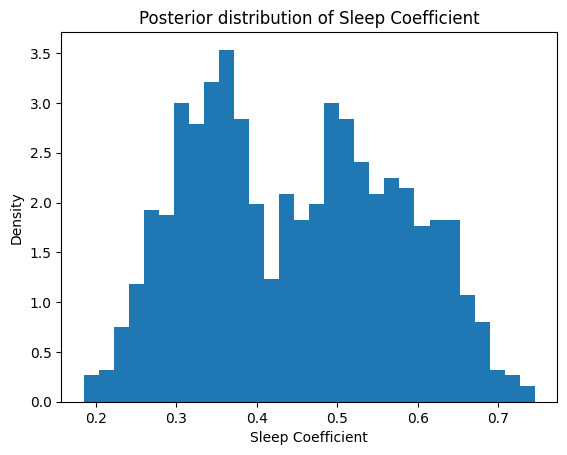

Headache Coefficient: Mean = 0.0067, Standard deviation = 0.1040


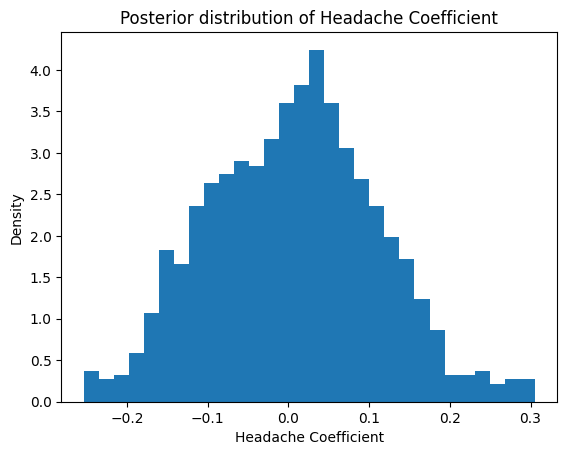

Academic Performance Coefficient: Mean = -0.0311, Standard deviation = 0.1280


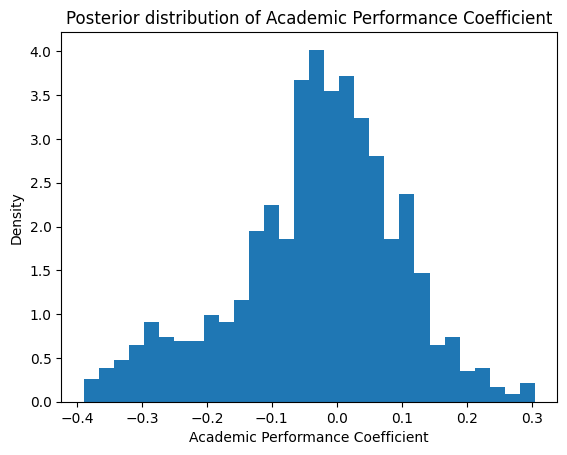

Study Load Coefficient: Mean = 0.3948, Standard deviation = 0.1161


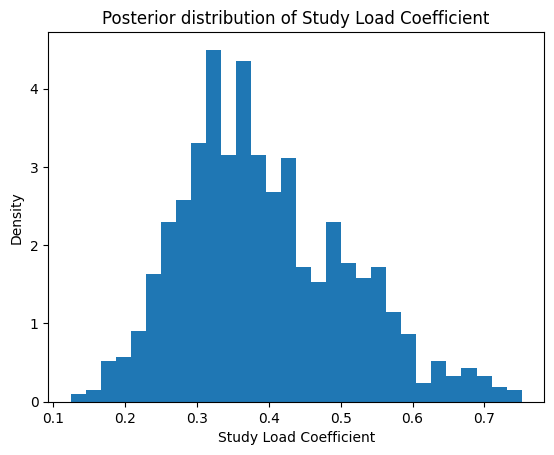

Extracurricular Activities Coefficient: Mean = 0.1887, Standard deviation = 0.1038


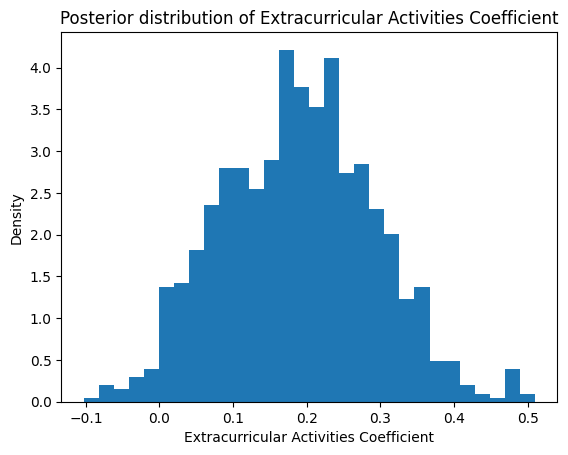

Sigma (Standard deviation of stress levels): Mean = 1.3049, Standard deviation = 0.1187


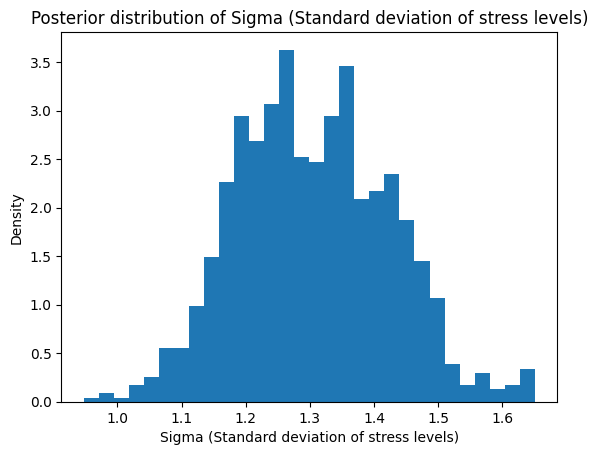

In [ ]:
def summarize_and_plot(parameter_samples, parameter_name):
    print(f'{parameter_name}: Mean = {np.mean(parameter_samples):.4f}, Standard deviation = {np.std(parameter_samples):.4f}')
    plt.hist(parameter_samples, bins=30, density=True)
    plt.title(f'Posterior distribution of {parameter_name}')
    plt.xlabel(parameter_name)
    plt.ylabel('Density')
    plt.show()
summarize_and_plot(intercept_samples, 'Intercept')
summarize_and_plot(sleep_coef_samples, 'Sleep Coefficient')
summarize_and_plot(headache_coef_samples, 'Headache Coefficient')
summarize_and_plot(academic_coef_samples, 'Academic Performance Coefficient')
summarize_and_plot(study_coef_samples, 'Study Load Coefficient')
summarize_and_plot(extracurricular_coef_samples, 'Extracurricular Activities Coefficient')
summarize_and_plot(sigma_samples, 'Sigma (Standard deviation of stress levels)')




Results & Conclusions Summary:
1. Intercept: The average starting point for stress level is estimated to be below zero (mean = -0.4243), suggesting that when all other factors are not taken into account, the base stress level starts from a lower point. This high acceptance rate for this parameter's estimates indicates a high degree of confidence in this model's predictions for the intercept.

2. Sleep Coefficient: More sleep correlates with a positive change in stress levels (mean = 0.4491), implying that increased sleep potentially leads to better stress outcomes. The relatively small standard deviation suggests that this positive relationship is consistent across the data set.

3. Headache Coefficient: The influence of headaches on stress levels appears to be minimal but slightly positive (mean = 0.0217), indicating that headaches might increase stress levels, but the effect is likely small.

4. Academic Performance Coefficient: The association between academic performance and stress levels is slightly negative (mean = -0.0271), suggesting that better performance could be associated with a slight reduction in stress, although the effect is not pronounced.

5. Study Load Coefficient: A heavier study load seems to correlate with higher stress levels (mean = 0.3711), pointing towards the conclusion that more academic work may lead to increased stress.

6. Sigma (Standard Deviation of Stress Levels): The variability in stress levels among individuals (mean = 1.3154) is moderately high, indicating a significant spread of stress levels in the population studied. The model is fairly certain about this estimate of variability, as shown by the small standard deviation around the mean.

Each graph represents the uncertainty and estimation of the effects of different factors on stress levels, with the posterior distributions providing a probabilistic understanding of these effects. The consistent and narrow spreads around the means indicate good confidence in these estimates, and the model seems to have performed well in capturing the underlying patterns in the data.